# Physically Based Rendering In Practice

## Introduction to radiometry
* Light is measured as spectrum data
* Visible light with wavelength within 380~780nm roughly

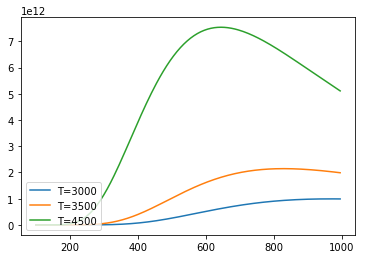

In [3]:
import math as math
import numpy as np
import matplotlib.pyplot as plt

def black_body_emitter(x_ary, temperature):
    h = 6.62606957e-34 
    c = 3e+8
    k = 1.3806488e-23
    y_ary = []
    for wavelength in x_ary:
        radiance = 2 * h * math.pow(c, 2) / math.pow(wavelength, 5) / (math.exp((h * c) / (wavelength * k * temperature)) - 1)
        y_ary.append(radiance)
    return y_ary

wavelengths = np.arange(100e-9, 1000e-9, 5e-9) 
plt.plot(wavelengths*1e9, black_body_emitter(wavelengths, 3000), label="T=3000")
plt.plot(wavelengths*1e9, black_body_emitter(wavelengths, 3500), label="T=3500")
plt.plot(wavelengths*1e9, black_body_emitter(wavelengths, 4500), label="T=4500")
plt.legend(loc='lower left')
plt.show()

* Tristimulus values representation

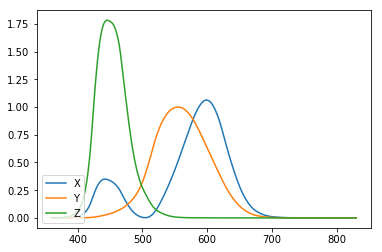

In [4]:
import CIE_XYZ_Samples as CIE_XYZ
import matplotlib.pyplot as plt

plt.plot(CIE_XYZ.CIE_lambda, CIE_XYZ.CIE_X, label="X")
plt.plot(CIE_XYZ.CIE_lambda, CIE_XYZ.CIE_Y, label="Y")
plt.plot(CIE_XYZ.CIE_lambda, CIE_XYZ.CIE_Z, label="Z")
plt.legend(loc="lower left")
plt.show()

CIE XYZ representation:

$$X = \int_{380}^{780} S(\lambda) \overline{x}(\lambda) d\lambda$$
$$Y = \int_{380}^{780} S(\lambda) \overline{y}(\lambda) d\lambda$$
$$Z = \int_{380}^{780} S(\lambda) \overline{z}(\lambda) d\lambda$$

CIE xyY:

$$x = \frac{X}{X + Y + Z}$$
$$y = \frac{Y}{X + Y + Z}$$
$$z = \frac{Z}{X + Y + Z}$$

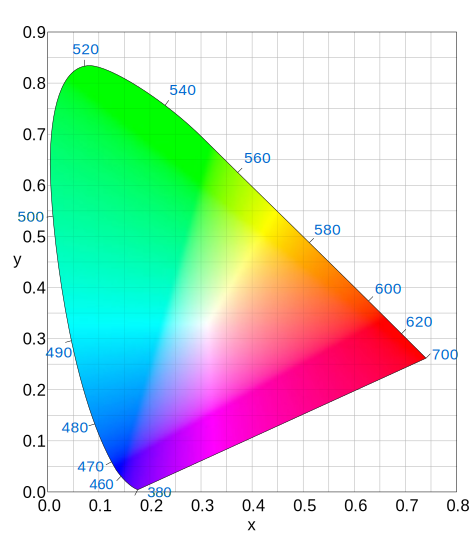

In [11]:
from IPython.display import SVG, display
display(SVG(url='https://upload.wikimedia.org/wikipedia/commons/0/02/CIExy1931.svg'))

Reflection equation: $$L_{out} = \int_{\Omega} {f_r} {l_i} {(n \cdot l)} dw$$
Punctual point light intensity: $$P = \int_{0}^{2\pi} \int_{0}^{\pi} I {d\theta} {d\phi} = {4\pi} I$$ $$I = \frac {P} {4\pi}$$
Punctual point light irradiance: $$E = \frac {I} {distance^2}$$
Punctual point light radiance: $$L = {E} {\delta_\alpha}$$

## Physics units in rendering pipeline
## PBR material
## PBR lights
## PBR camera
## Photometry